In [207]:
using DifferentialEquations
using ReactionMechanismSimulator
using PyPlot

In [208]:
outdict = readinput("chem300.rms")

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [209]:
liqspcs = outdict["gas"]["Species"]
liqrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [210]:
sitedensity = 2.292e-5; # Ag111
liq = IdealDiluteSolution(liqspcs,liqrxns,solv,name="liquid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [211]:
initialcondsliq = Dict(["proton"=>10.0^-4,
        "CO2"=>10.0^-3*10^6,
        "V"=>1.0,"T"=>300,"Phi"=>0.0,"d"=>0.0]);
AVratio = 1e5;
initialcondssurf = Dict(["CO2X"=>0.4*sitedensity*AVratio,
        "CHO2X"=>0.1*sitedensity*AVratio,
        "CO2HX"=>0.1*sitedensity*AVratio,
        "OX"=>0.1*sitedensity*AVratio,
        "OCX"=>0.1*sitedensity*AVratio,
        "vacantX"=>0.1*sitedensity*AVratio,
        "CH2O2X"=>0.05*sitedensity*AVratio,
        "CHOX"=>0.04*sitedensity*AVratio,
        "CH2OX"=>0.01*sitedensity*AVratio,
        "A"=>1.0*AVratio,"T"=>300,"Phi"=>-1.0]);

In [212]:
domainliq,y0liq,pliq = ConstantTVDomain(phase=liq,
    initialconds=initialcondsliq,constantspecies=["proton","CO2"]);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [213]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainliq,
  domaincat,interfacerxns,298.15,AVratio*1.0);

In [214]:
@time react,y0,p = Reactor((domainliq,domaincat), (y0liq,y0cat), (0.0, 1.0e2), [inter], (pliq,pcat,pinter));


In [215]:
@time sol = solve(react.ode,DifferentialEquations.CVODE_BDF(),abstol=1e-16,reltol=1e-8);

In [216]:
sol

retcode: Success
Interpolation: 3rd order Hermite
t: 7461-element Vector{Float64}:
   0.0
   5.660416427572942e-20
   1.1320832855145884e-19
   2.902309168337864e-19
   4.67253505116114e-19
   6.442760933984415e-19
   9.231488374392386e-19
   1.3898300635349888e-18
   2.193644710893448e-18
   3.578897884254759e-18
   ⋮
  91.83301253862255
  92.88191460888021
  93.93081667913786
  94.97971874939552
  96.02862081965317
  97.07752288991082
  98.12642496016848
  99.17532703042613
 100.0
u: 7461-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 1000.0, 0.0001, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 1000.0, 0.0001, 8.17184100610347e-155, 5.185322460533866e-19, 1.9322225419002214e-19, 3.243418612979729e-14  …  3.661486801026795e-54, 5.388257620714703e-73, 5.045807323460488e-95, -2.4111356659384226e-186, 1.918190076724916e-86, 3.002928215427436e-103, 1.432127791998723e-75, 5.580544417206603e-113, 5.360679208003009e-51, 2.255437263643

In [217]:
sol.retcode

ReturnCode.Success = 1

In [218]:
ssys = SystemSimulation(sol,(domainliq,domaincat,),(inter,),p);

In [219]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [220]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

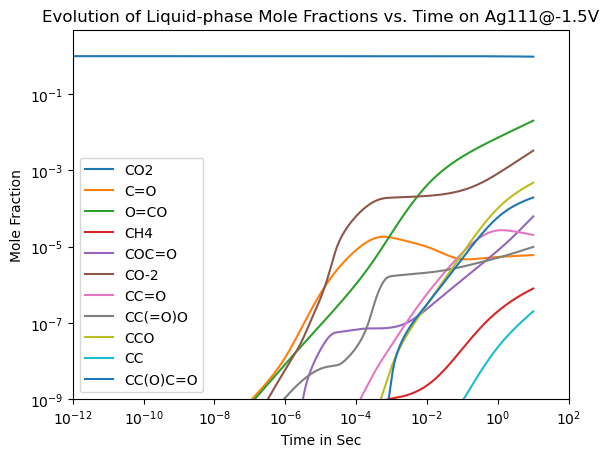

In [221]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-6, 1e1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e2)
ylim(1e-9, 5)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

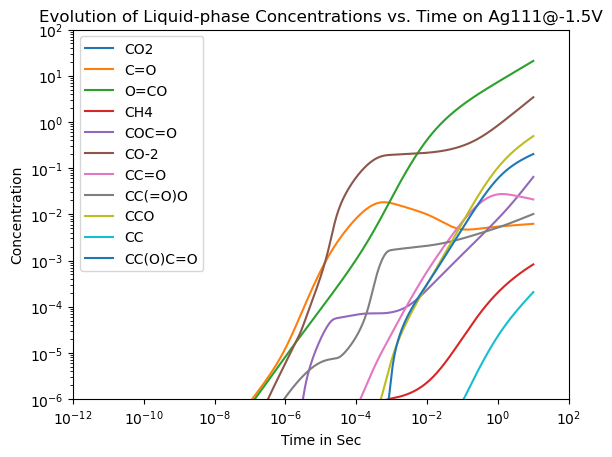

In [222]:
exclude_species = ["H2O"]
plotC(ssys.sims[1], 1e-3, 1e1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e2)
ylim(1e-6, 1e2)
title("Evolution of Liquid-phase Concentrations vs. Time on Ag111@-1.5V")
gcf()

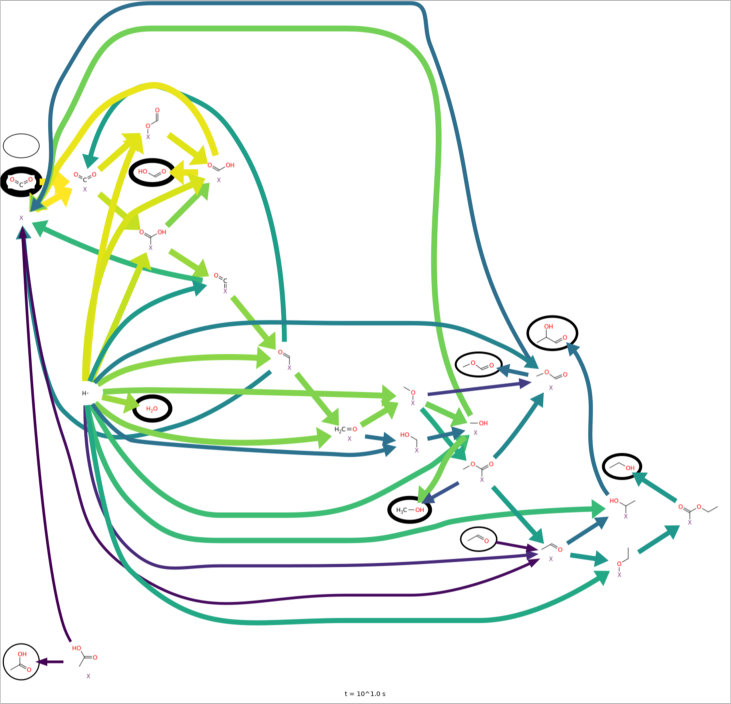

In [223]:
getfluxdiagram(ssys,10;speciesratetolerance=1e-6)

In [224]:
println(ssys.names)

In [225]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

In [226]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end